# KSTAR Example Analysis using BCR-ABL

## Way 1 : Use run_star_analysis to do the following
1. Map data
2. Run KSTAR analysis 
3. Generate random experiments
4. Find FPR p-value
5. Normalize data
6. Save all data

In [1]:
import pandas as pd
from kstar import kstar_runner, helpers

odir = '/Users/bj8th/Documents/GitHub/KSTAR/analysis/BCR-ABL'
name = 'BCR-ABL'
run_log = helpers.get_logger(f"{name}_run", f"{odir}/{name}_run.log")

experiment = pd.read_csv('/Users/bj8th/Documents/GitHub/KSTAR/analysis/BCR-ABL/PRE-MAPPED/experiment.1704.tsv', sep = '\t')
experiment.rename(columns={'average:data:treated_to_untreated:EOE(drug washout)' : 'EOE',
       'average:data:treated_to_untreated:HDP3(3hrs post treatment)' :'HDP3',
       'average:data:treated_to_untreated:HDP6(6hrs post treatment)' :'HDP6',
       'average:data:treated_to_untreated:pre-treatment' : 'PRE'}, inplace=True)

map_columns = {'peptide':'aligned_peptides', 'accession_id':'query_accession'}
data_columns = ['EOE','HDP3','HDP6','PRE']
window = 7
phospho_types = ['Y']
activity_agg = 'mean'
threshold = 0.5
greater = True
normalize = True
num_random_experiments = 2
target_alpha = 0.05

kstar_runner.run_kstar_analysis(
    run_log, 
    odir, 
    name, 
    experiment, 
    data_columns, 
    map_columns, 
    window, 
    phospho_types, 
    activity_agg, 
    threshold, 
    greater, 
    normalize,
    num_random_experiments, 
    target_alpha
)



## Way 2 : Manually Run STAR analysis

In [61]:
import pandas as pd
from kstar import kstar_runner

from kstar.activity import kstar_activity
from kstar.mapper import experiment_mapper
from kstar import helpers, config

import pickle

In [62]:
odir = '/Users/bj8th/Documents/GitHub/KSTAR/analysis/BCR-ABL'
name = 'BCR-ABL'

### 1. Load pre-mapped experiment and map experiment


In [63]:
# Load Data
pre_mapped = pd.read_csv('/Users/bj8th/Documents/GitHub/KSTAR/analysis/BCR-ABL/PRE-MAPPED/experiment.1704.tsv', sep = '\t')
pre_mapped.rename(columns={'average:data:treated_to_untreated:EOE(drug washout)' : 'EOE',
       'average:data:treated_to_untreated:HDP3(3hrs post treatment)' :'HDP3',
       'average:data:treated_to_untreated:HDP6(6hrs post treatment)' :'HDP6',
       'average:data:treated_to_untreated:pre-treatment' : 'PRE'}, inplace=True)

In [64]:
#set column names dictionary, need at least a site and accession or peptide/accession, or all three
map_dict = {'peptide':'aligned_peptides', 'accession_id':'query_accession'}
data_columns = ['EOE','HDP3','HDP6','PRE']

if not os.path.exists(f"{odir}/MAPPED_DATA"): 
    os.mkdir(f"{odir}/MAPPED_DATA")   
mapping_log = helpers.get_logger(f"mapping_{name}", f"{odir}/MAPPED_DATA/mapping_{name}.log")
exp_mapper = experiment_mapper.ExperimentMapper(experiment = pre_mapped,
                                                columns = map_dict, 
                                                logger = mapping_log,
                                                data_columns = data_columns)
exp_mapper.experiment.to_csv(f"{odir}/MAPPED_DATA/{name}_mapped.tsv", sep = '\t', index = False)



### 2. Run Kinase Activity Analysis on Experiment

In [65]:
# experiment = pd.read_csv('/Users/bj8th/Documents/GitHub/KSTAR/analysis/BCR-ABL/MAPPED_DATA/BCR-ABL_mapped.tsv', sep = '\t')
experiment = exp_mapper.experiment

In [66]:
#get logger for analysis
if not os.path.exists(f"{odir}/RESULTS"): 
    os.mkdir(f"{odir}/RESULTS") 
activity_log = helpers.get_logger(name, f'{odir}/RESULTS/{name}_kstar_activity.log')

In [67]:
phospho_types = ['Y'] #running on this type of kinase/substrate network

#preamble, setup the network dictionary. Here, using the default pickles from config
# only have to load one of these if running analysis on only one substrate type
networks = {}
networks['Y'] = pickle.load(open(config.NETWORK_Y_PICKLE, "rb" ) )
#networks['ST'] = pickle.load(open(config.NETWORK_ST_PICKLE, "rb" ) )

In [68]:
agg = 'mean'
threshold = 0.5
greater = True
kinact_dict = kstar_activity.run_kstar_analysis(experiment, activity_log, networks, phospho_types = phospho_types, data_columns = None, agg =agg, threshold = threshold,  greater = greater)

### 3. Normalize experiment activity results

In [69]:
num_random_experiments=2
target_alpha=0.05
kstar_activity.normalize_analysis(kinact_dict, activity_log, num_random_experiments, target_alpha)

### 4. Save Results

In [ ]:
kstar_activity.save_kstar(kinact_dict, name, odir)

In [70]:
kinact = kinact_dict['Y']
kinact.random_experiments.sum()

KSTAR_ACCESSION    A0AUZ9A0AV02A0AVF1A0AVF1A0AVI2A0AVK6A0AVK6A0AV...
KSTAR_SITE         Y792Y107Y167Y174Y1801Y202Y316Y1046Y44Y558Y979Y...
data:EOE:0                                                        94
data:EOE:1                                                        94
data:HDP3:0                                                       81
data:HDP3:1                                                       81
data:HDP6:0                                                       92
data:HDP6:1                                                       92
data:PRE:0                                                       161
data:PRE:1                                                       161
dtype: object

In [13]:
experiment = kinact.evidence.groupby(['KSTAR_ACCESSION', 'KSTAR_SITE']).agg(kinact.aggregate)
for col in kinact.data_columns:
    print(f"{col}: {len(experiment[experiment[col] >= kinact.threshold])}")

data:EOE: 94
data:HDP3: 81
data:HDP6: 92
data:PRE: 161


# Plotting

In [57]:
from kstar.plot import dotplot
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
kinact_dict = pickle.load(open(f"{odir}/RESULTS/{name}_kinact.p", "rb"))
kinact = kinact_dict['Y']

In [71]:
activities = kinact.normalized_summary
significant = (activities < kinact.normalizers)*1
activities = -np.log10(activities)

## Basic Dotplot

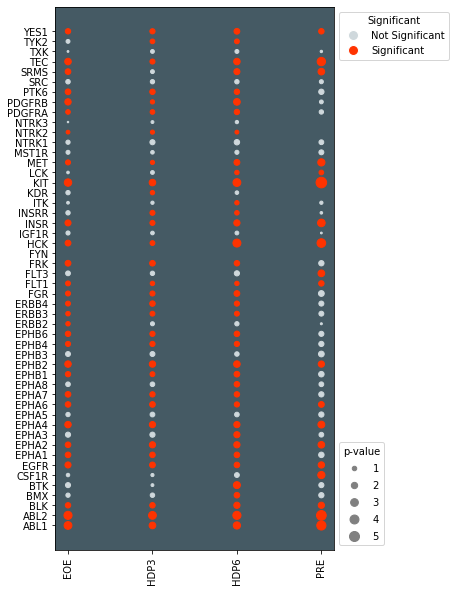

In [72]:
# ONLY plotting dotplot
dots = dotplot.DotPlot(
    values = activities, colors = significant, dotsize = 20, 
    colormap = {0 : '#CFD8DC', 1 : '#FF3300'}, 
    labelmap = {0 : 'Not Significant', 1 : 'Significant'},
    facecolor = '#455A64',
    legend_title = 'p-value', size_number = 5, size_color = 'gray', 
    color_title = 'Significant', markersize = 10, 
    legend_distance = 1.0, figsize = (5,10), title = None,
    xlabel = True, ylabel = True, x_label_dict = None
)
dots.dotplot()

## Hierarchical Clustering
Clustering must be done before the dotplot method is called

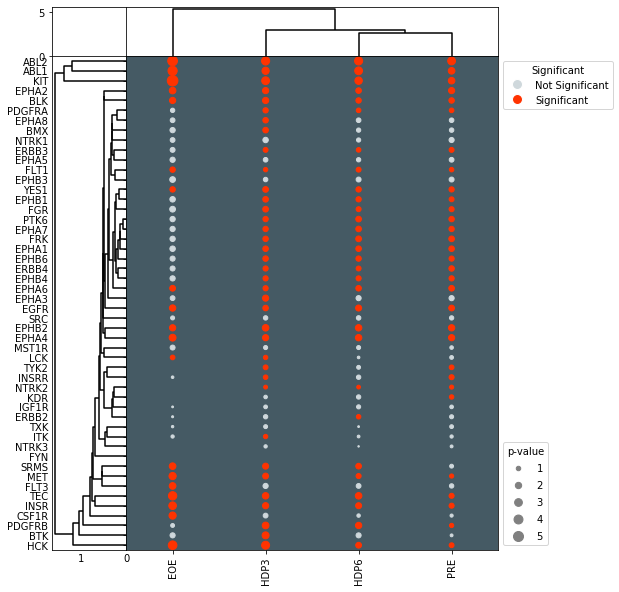

In [97]:
# To do clustering must do clustering brefore the dotplot() method - clustering changes locations of plots
fig, axes = plt.subplots(figsize = (8, 10), 
        nrows = 2, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.1,1,], 
            'width_ratios':[0.2,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)


dots = dotplot.DotPlot(
    values = activities, colors = significant, dotsize = 20, 
    colormap = {0 : '#CFD8DC', 1 : '#FF3300'}, 
    labelmap = {0 : 'Not Significant', 1 : 'Significant'},
    facecolor = '#455A64',
    legend_title = 'p-value', size_number = 5, size_color = 'gray', 
    color_title = 'Significant', markersize = 10, 
    legend_distance = 1.0, figsize = (5,10), title = None,
    xlabel = True, ylabel = True, x_label_dict = None
)

dots.cluster(orientation = 'left', ax = axes[1,0])
dots.cluster(orientation = 'top', ax = axes[0,1])
dots.dotplot(ax = axes[1,1])




# dots.context(ax=axes[2,1],info = s1, id_column = 'Sample', context_columns = ['Human Tumor Her2',], index = list(dots.values.columns) , orientation = 'bottom', dotsize =200, markersize= 15 )


## CONTEXT


In [113]:
import random
letters = 'KSTAR'
#build some context examples
experiment_context = pd.DataFrame({'experiment': list(activities.columns), 'exp_context1':['A','A','B','B'], 'exp_context2':['NO','YES','NO','MAYBE']})
kinases = list(activities.index)
kinase_context = pd.DataFrame({'kinase' : kinases, 'kin_context': [letters[random.randint(0, 4)] for i in range(len(kinases))]})

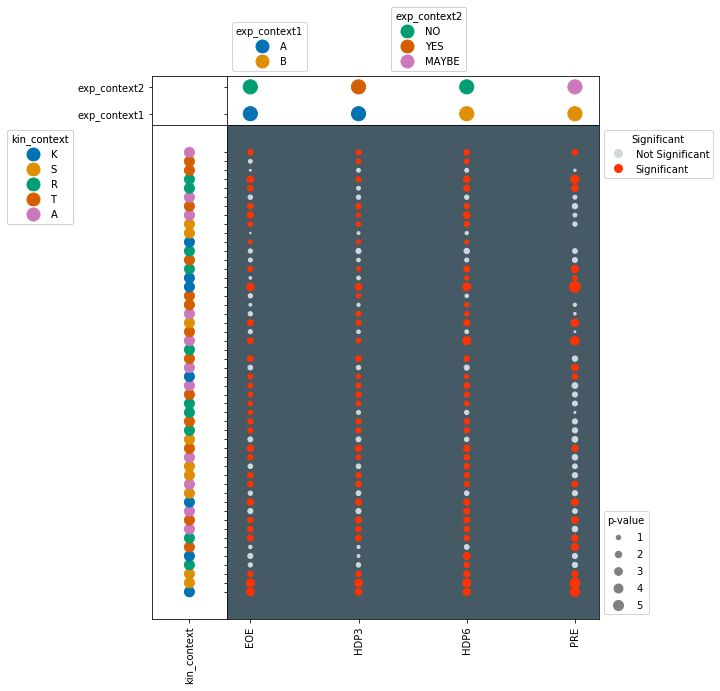

In [114]:
# CONTEXT

fig, axes = plt.subplots(figsize = (8, 10), 
        nrows = 2, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.1,1,], 
            'width_ratios':[0.2,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)


dots = dotplot.DotPlot(
    values = activities, colors = significant, dotsize = 20, 
    colormap = {0 : '#CFD8DC', 1 : '#FF3300'}, 
    labelmap = {0 : 'Not Significant', 1 : 'Significant'},
    facecolor = '#455A64',
    legend_title = 'p-value', size_number = 5, size_color = 'gray', 
    color_title = 'Significant', markersize = 10, 
    legend_distance = 1.0, figsize = (5,10), title = None,
    xlabel = True, ylabel = True, x_label_dict = None
)
dots.dotplot(ax = axes[1,1])

dots.context(ax=axes[0,1],info = experiment_context, id_column = 'experiment', context_columns = ['exp_context1','exp_context2'], orientation = 'top', dotsize =200, markersize= 15 )
dots.context(ax = axes[1,0], info = kinase_context, id_column = 'kinase', context_columns=['kin_context'], orientation = 'left', dotsize=100, markersize=15)


## COMBINING CLUSTING AND CONTEXT

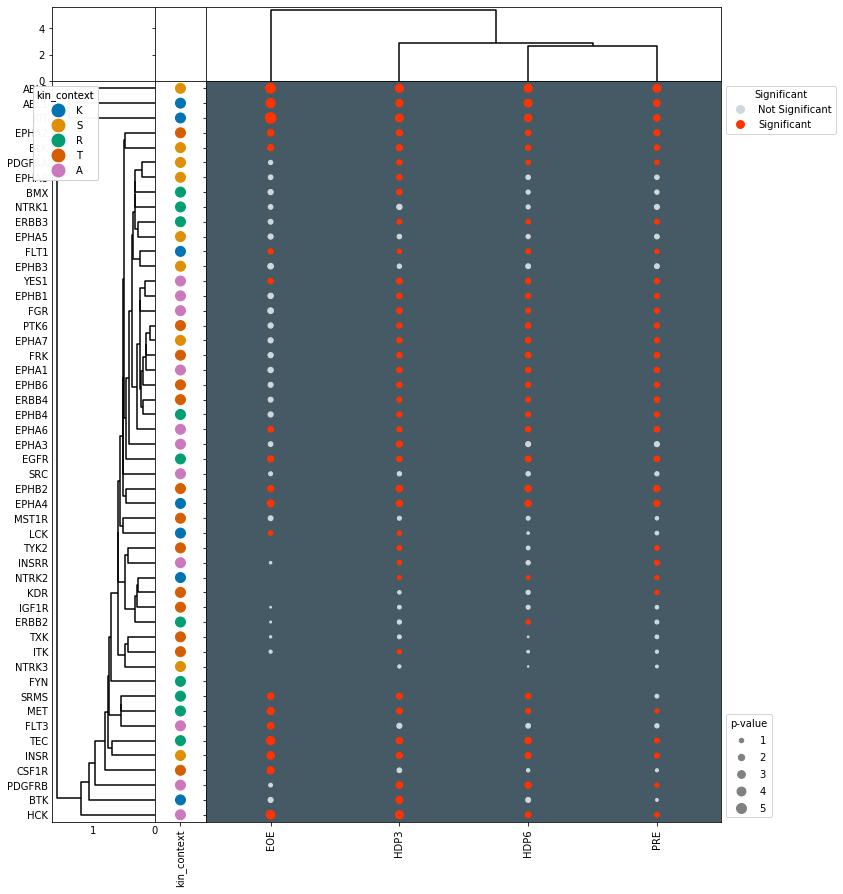

In [126]:
# COMBINED

fig, axes = plt.subplots(figsize = (12, 15), 
        nrows = 2, ncols = 3, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[.1,1], 
            'width_ratios':[0.2,0.1, 1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)


dots = dotplot.DotPlot(
    values = activities, colors = significant, dotsize = 20, 
    colormap = {0 : '#CFD8DC', 1 : '#FF3300'}, 
    labelmap = {0 : 'Not Significant', 1 : 'Significant'},
    facecolor = '#455A64',
    legend_title = 'p-value', size_number = 5, size_color = 'gray', 
    color_title = 'Significant', markersize = 10, 
    legend_distance = 1.0, title = None,
    xlabel = True, ylabel = True, x_label_dict = None
)

dots.cluster(orientation = 'left', ax = axes[1,0])
dots.cluster(orientation = 'top', ax = axes[0,2])
dots.dotplot(ax = axes[1,2])

dots.context(ax = axes[1,1], info = kinase_context, id_column = 'kinase', context_columns=['kin_context'], orientation = 'left', dotsize=100, markersize=15)
